In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
################################################## Trabajando con el nem de los jóvenes
df_jovenes = pd.read_csv("nem_jovenes.csv", header=0, sep=";", encoding = "utf-8")
columnas_a_convertir = ["RBD", "COD_DEPE", "AGNO_EGRESO", "MRUN", "PERCENTIL"]
for i in columnas_a_convertir:
    df_jovenes[i] = df_jovenes[i].astype(str)

df_jovenes["NEM"] = df_jovenes["NEM"].str.replace(",", ".").astype(float)
df_jovenes

quantiles_jovenes = df_jovenes.groupby("RBD")["NEM"].quantile([0.25, 0.5, 0.75]).unstack()
# Renombrando las columnas de los quantiles
quantiles_jovenes.columns = ['25th_jovenes', '50th_jovenes', '75th_jovenes']
df_jovenes = df_jovenes.merge(quantiles_jovenes, left_on="RBD", right_index=True, suffixes=("", "_quantiles"))
df_jovenes["Outlier"] = np.where((df_jovenes["NEM"] < df_jovenes["25th_jovenes"] - 1.5 * (df_jovenes["75th_jovenes"] - df_jovenes["25th_jovenes"])), 1, 0)
print(df_jovenes.describe())
print(df_jovenes["Outlier"].value_counts())

                 NEM   25th_jovenes   50th_jovenes   75th_jovenes  \
count  212887.000000  212887.000000  212887.000000  212887.000000   
mean        5.939064       5.602673       5.940954       6.283580   
std         0.537844       0.319531       0.309386       0.268788   
min         4.180000       4.750000       5.000000       5.000000   
25%         5.530000       5.365000       5.700000       6.080000   
50%         5.950000       5.550000       5.915000       6.280000   
75%         6.380000       5.800000       6.150000       6.490000   
max         7.000000       6.790000       6.880000       6.980000   

             Outlier  
count  212887.000000  
mean        0.003189  
std         0.056386  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
Outlier
0    212208
1       679
Name: count, dtype: int64


In [ ]:
################################################## trabajando con el nem de los adultos
df_adultos = pd.read_csv("nem_adultos.csv", header=0, sep=";", encoding = "utf-8")
columnas_a_convertir = ["RBD", "COD_DEPE", "AGNO_EGRESO", "MRUN", "PERCENTIL"]
for i in columnas_a_convertir:
    df_adultos[i] = df_adultos[i].astype(str)

df_adultos["NEM"] = df_adultos["NEM"].str.replace(",", ".").astype(float)
quantiles_adultos = df_adultos.groupby("RBD")["NEM"].quantile([0.25, 0.5, 0.75]).unstack()

# Renombrar las columnas de los cuartiles
quantiles_adultos.columns = ['25th_adultos', '50th_adultos', '75th_adultos']
df_adultos = df_adultos.merge(quantiles_adultos, left_on="RBD", right_index=True, suffixes=("", "_quantiles"))
df_adultos["Outlier"] = np.where((df_adultos["NEM"] < df_adultos["25th_adultos"] - 1.5 * (df_adultos["75th_adultos"] - df_adultos["25th_adultos"])), 1, 0)
print(df_adultos.describe())
print(df_adultos["Outlier"].value_counts())

                NEM  25th_adultos  50th_adultos  75th_adultos       Outlier
count  49541.000000  49541.000000  49541.000000  49541.000000  49541.000000
mean       5.454784      5.099267      5.402163      5.772897      0.001978
std        0.543949      0.204145      0.222923      0.269580      0.044433
min        4.000000      4.375000      4.530000      4.530000      0.000000
25%        5.070000      4.970000      5.285000      5.600000      0.000000
50%        5.400000      5.100000      5.400000      5.800000      0.000000
75%        5.800000      5.230000      5.530000      5.930000      0.000000
max        7.000000      6.270000      6.630000      6.700000      1.000000
Outlier
0    49443
1       98
Name: count, dtype: int64


In [ ]:
################################################## Se contabiliza los outliers en cada grupo
outliers_jovenes = df_jovenes[df_jovenes["Outlier"] == 1].groupby("RBD").size().reset_index(name="Outliers_jovenes")
outliers_adultos = df_adultos[df_adultos["Outlier"] == 1].groupby("RBD").size().reset_index(name="Outliers_adultos")
outliers = outliers_jovenes.merge(outliers_adultos, on="RBD", how="outer").fillna(0)
outliers

,RBD,Outliers_jovenes,Outliers_adultos
0,10455,1.0,0.0
1,10492,1.0,0.0
2,10512,1.0,0.0
3,10606,1.0,0.0
4,10610,3.0,0.0
...,...,...,...
442,7,0.0,1.0
443,7200,0.0,2.0
444,7629,0.0,1.0
445,8394,0.0,1.0


In [ ]:
################################################## Se unen los outliers con el dataset original
df_SEP = pd.read_csv("SEP.csv", sep=";", encoding="utf-8")

# Mapeo de valores de texto a numéricos
clasificacion_map = {
    '': 0,  # Vacío: establecimiento sin convenio SEP
    'AUTONOMO': 3,
    'EMERGENTE': 2,
    'EN RECUPERACION': 1
}

# Aplicar la conversión de texto a numérico
df_SEP['CLASIFICACION_SEP'] = df_SEP['CLASIFICACION_SEP'].fillna('').map(clasificacion_map)

# Reemplazar los valores no encontrados en el mapeo con 0 (por ejemplo, valores NaN)
df_SEP['CLASIFICACION_SEP'] = df_SEP['CLASIFICACION_SEP'].fillna(0).astype('int64')

# Convertir otras columnas al tipo de dato especificado
df_SEP = df_SEP.astype({
    'AGNO': 'str',
    'RBD': 'str',
    'COD_REG_RBD': 'str',
    'COD_PRO_RBD': 'str',
    'NOM_COM_RBD': 'str',
    'COD_DEPE': 'str',
    'CONVENIO_SEP': 'int64',
    'CLASIFICACION_SEP': 'int64',
    'N_PRIO': 'int64',
    'N_PRIO_BEN': 'int64',
    'N_PREF': 'int64',
    'N_PREF_BEN': 'int64',
    'N_BEN': 'int64'
})

# Filtrar el DataFrame para mantener solo las columnas especificadas
df_SEP = df_SEP[[
    'AGNO',
    'RBD',
    'COD_REG_RBD',
    'COD_PRO_RBD',
    'NOM_COM_RBD',
    'COD_DEPE',
    'CONVENIO_SEP',
    'CLASIFICACION_SEP',
    'N_PRIO',
    'N_PRIO_BEN',
    'N_PREF',
    'N_PREF_BEN',
    'N_BEN'
]]


# Unir la base de outliers por NEM descrita anteriormente
df_SEP = df_SEP.merge(outliers, on="RBD", how="left").fillna(0)

# Filtrar los datos para trabajar solamente con la región Metropolitana
df_SEP = df_SEP[df_SEP['COD_REG_RBD'] == '13']

# Mostrar los resultados
df_SEP.head()

,AGNO,RBD,COD_REG_RBD,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPE,CONVENIO_SEP,CLASIFICACION_SEP,EE_GRATUITO,N_PRIO,N_PRIO_BEN,N_PREF,N_PREF_BEN,N_BEN,Outliers_jovenes,Outliers_adultos
4899,2023,8485,13,131,13101,SANTIAGO,2,1,3,1,1368,1368,1171,1171,2539,11.0,0.0
4900,2023,8487,13,131,13101,SANTIAGO,2,1,2,1,1094,1094,855,855,1949,17.0,0.0
4901,2023,8488,13,131,13101,SANTIAGO,2,1,2,1,126,126,59,59,185,0.0,0.0
4902,2023,8489,13,131,13101,SANTIAGO,2,1,2,1,188,188,96,96,284,0.0,0.0
4903,2023,8490,13,131,13101,SANTIAGO,2,1,1,1,194,194,94,94,288,1.0,0.0


In [ ]:
print(df_SEP.isnull().sum())
print(df_SEP["RBD"].nunique())

AGNO                 0
RBD                  0
COD_REG_RBD          0
COD_PRO_RBD          0
COD_COM_RBD          0
NOM_COM_RBD          0
COD_DEPE             0
CONVENIO_SEP         0
CLASIFICACION_SEP    0
EE_GRATUITO          0
N_PRIO               0
N_PRIO_BEN           0
N_PREF               0
N_PREF_BEN           0
N_BEN                0
Outliers_jovenes     0
Outliers_adultos     0
dtype: int64
2888


In [ ]:
# Definir las columnas a analizar para outliers
columnas_outliers = ['N_PRIO', 'N_PRIO_BEN', 'N_PREF', 'N_PREF_BEN', 'N_BEN']

# Crear un diccionario para almacenar los resultados de outliers
outliers_info = {}

# Calcular el rango intercuartílico (IQR) y los límites de los outliers para cada columna
for col in columnas_outliers:
    Q1 = df_SEP[col].quantile(0.25)
    Q3 = df_SEP[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_SEP[df_SEP[col] > upper_bound]
    outliers_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
    }

outliers_info

{'N_PRIO': {'Q1': 34.0,
  'Q3': 299.25,
  'IQR': 265.25,
  'Lower Bound': -363.875,
  'Upper Bound': 697.125,
  'Outliers Count': 131},
 'N_PRIO_BEN': {'Q1': 0.0,
  'Q3': 265.0,
  'IQR': 265.0,
  'Lower Bound': -397.5,
  'Upper Bound': 662.5,
  'Outliers Count': 142},
 'N_PREF': {'Q1': 16.0,
  'Q3': 139.0,
  'IQR': 123.0,
  'Lower Bound': -168.5,
  'Upper Bound': 323.5,
  'Outliers Count': 234},
 'N_PREF_BEN': {'Q1': 0.0,
  'Q3': 87.0,
  'IQR': 87.0,
  'Lower Bound': -130.5,
  'Upper Bound': 217.5,
  'Outliers Count': 264},
 'N_BEN': {'Q1': 0.0,
  'Q3': 367.25,
  'IQR': 367.25,
  'Lower Bound': -550.875,
  'Upper Bound': 918.125,
  'Outliers Count': 153}}

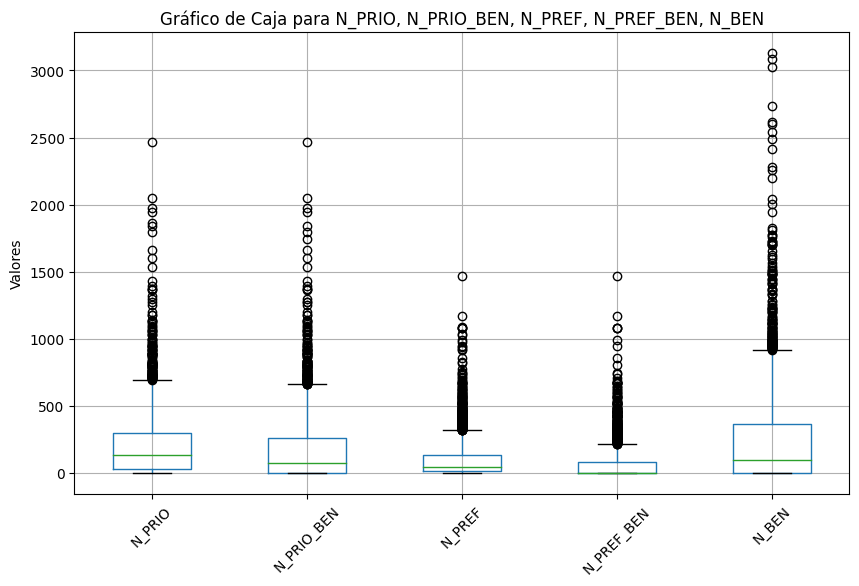

In [ ]:
# Crear un gráfico de caja (boxplot) para las columnas seleccionadas
plt.figure(figsize=(10, 6))
df_SEP[['N_PRIO', 'N_PRIO_BEN', 'N_PREF', 'N_PREF_BEN', 'N_BEN']].boxplot()
plt.title('Gráfico de Caja para N_PRIO, N_PRIO_BEN, N_PREF, N_PREF_BEN, N_BEN')
plt.ylabel('Valores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

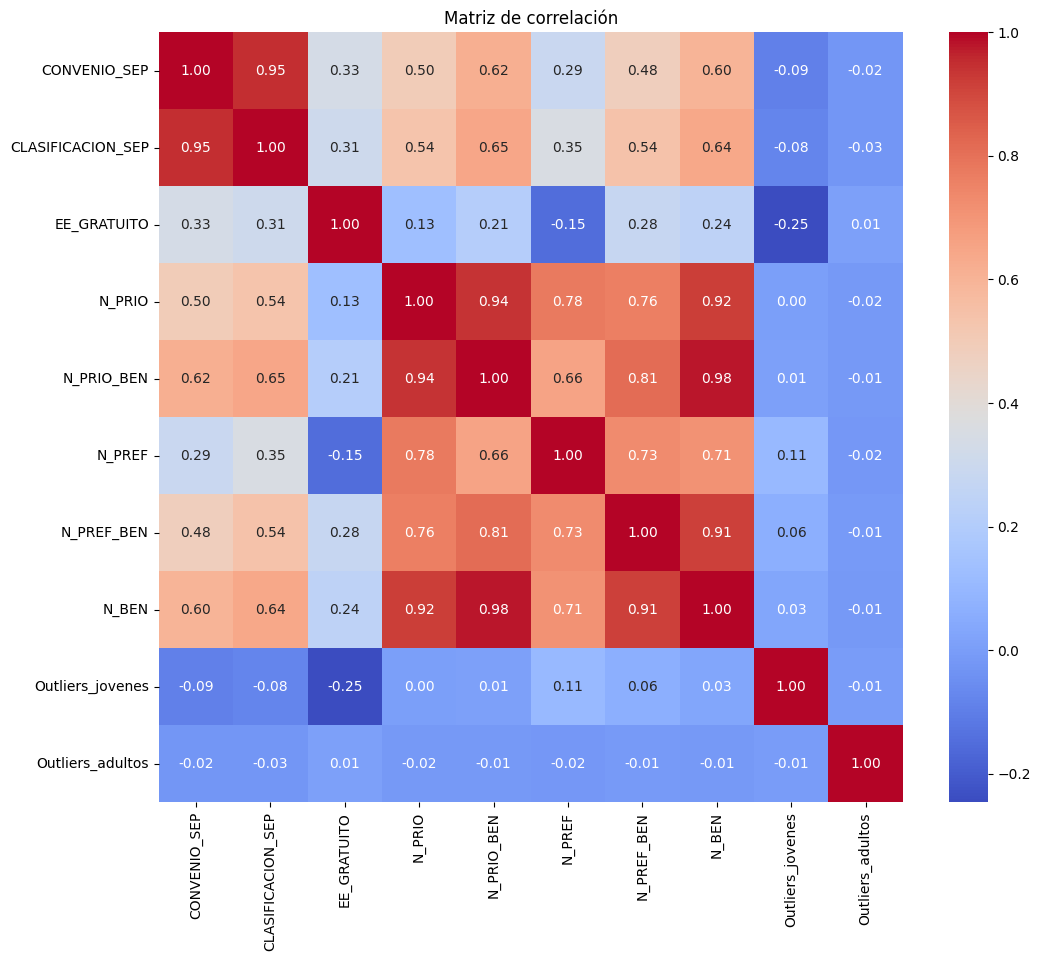

In [ ]:
import seaborn as sns

# Seleccionar las columnas numéricas
numeric_df_SEP = df_SEP.select_dtypes(include=np.number)

# Calcular la matriz de correlación
corr_matrix = numeric_df_SEP.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()


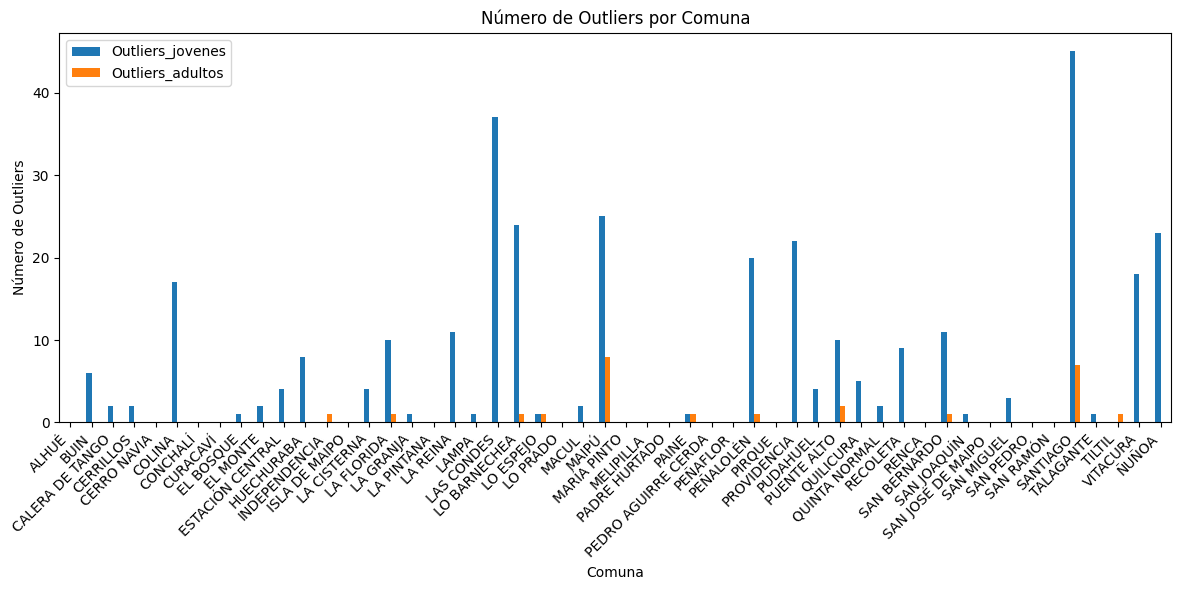

In [ ]:
outliers_grouped = df_SEP.groupby("NOM_COM_RBD")[["Outliers_jovenes", "Outliers_adultos"]].sum()
outliers_grouped.plot(kind="bar", stacked=False, figsize=(12, 6))
plt.xlabel("Comuna")
plt.ylabel("Número de Outliers")
plt.title("Número de Outliers por Comuna")
plt.legend(["Outliers_jovenes", "Outliers_adultos"])

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')

# Ajustar el diseño para evitar que las etiquetas se corten
plt.tight_layout()

plt.show()

In [ ]:
# Filtrar los colegios con al menos un 'N_PREF' y al menos un outlier en jóvenes o adultos
colegios_con_outliers = df_SEP[
    (df_SEP['N_PREF'] > 0) &
    ((df_SEP['Outliers_jovenes'] > 0) | (df_SEP['Outliers_adultos'] > 0))
]['RBD'].nunique()

# Total de colegios con al menos un 'N_PREF'
total_colegios_con_N_PREF = df_SEP[df_SEP['N_PREF'] > 0]['RBD'].nunique()

# Calcular la fracción del total de colegios con al menos un 'N_PREF' que tienen al menos un outlier
fraccion_colegios_con_outliers = colegios_con_outliers / total_colegios_con_N_PREF

# Mostrar resultados
print(f"Colegios con al menos un 'N_PREF' y un outlier: {colegios_con_outliers}")
print(f"Total de colegios con al menos un 'N_PREF': {total_colegios_con_N_PREF}")
print(f"Fracción de colegios con outliers: {fraccion_colegios_con_outliers:.2%}")



Colegios con al menos un 'N_PREF' y un outlier: 173
Total de colegios con al menos un 'N_PREF': 2875
Fracción de colegios con outliers: 6.02%
